In [1]:
import numpy as np
import PIL as pil
import matplotlib.pyplot as plt
%matplotlib inline
#import cv2
import scipy
import scipy.misc
import scipy.signal
import warnings
import os
import re
import copy
warnings.filterwarnings("ignore", category=DeprecationWarning) 
#plt.rcParams['figure.figsize'] = (50,50)
plt.rcParams['image.cmap'] = 'gray'
import mrc as mrc
import version1 as v1
import version2 as v2
import version3 as v3
import version4 as v4

## Working with MRC files, this code accomodates particle stacks
Builds up from taking in a stack and image and outputting a stack of nccs, to improving the code via efficiency, and finally combining the nccs into Ek for the probability calculations. 

Wall time: 6.75 s


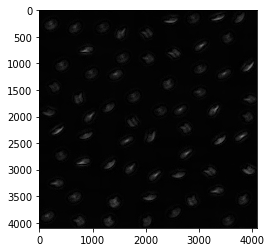

In [2]:
%%time
t = v4.multi_particles4('imgdata_52006_1.mrc', 'imgdata_26005_particle_stack.mrc',1, use_numpy_ver = True) 
plt.imshow(t[:,:,0])

In [150]:
%%time
t = v4.multi_particles4('imgdata_52006_1_4096.mrc', 'imgdata_26005_particle_stack_512.mrc',40, use_numpy_ver = True)

2min 43s ± 2.09 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [151]:
%%time
t = v3.multi_particles3('imgdata_52006_1_4096.mrc', 'imgdata_26005_particle_stack_512.mrc',40, use_numpy_ver = True)

3min 12s ± 1.97 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [152]:
%%time
t = v1.multi_particles1('imgdata_52006_1_4096.mrc', 'imgdata_26005_particle_stack_512.mrc',40, use_numpy_ver = True)

3min 43s ± 1.97 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


First version, takes in a parameter of a number which corresponds to the amount of nccs produced by the first n projections of the template stack. 

In [5]:
%%time
#Version 1 to loop through particles
def normalized_cc(I,T, use_numpy_ver=True):
    T = T - np.mean(T)
    # zero padding the template
    I = I[:,:,0]
    [height,length] = I.shape
    [bheight,blength] = T.shape
    
    x = [height/2-bheight/2]
    y = [length/2-bheight/2]
    x = int(x[0])
    y = int(y[0])
    
    padding = np.zeros_like(I)
    
    # Create mask of zero-padded template
    padding[x:x+int(T.shape[0]), y:y+int(T.shape[1])]=1.0
    
    
    # Compute correlations of I and I**2
    crossc = fast_convolve(I,T[::-1,::-1],use_numpy_ver)
    denom1 = np.sqrt(fast_convolve(I**2, padding,use_numpy_ver))
    denom2 = np.sqrt(np.sum((T**2)))
    
    # Compute and return normalized cross-correlation
    ncc = abs(crossc/(denom1*denom2))
#   plt.imshow(abs(ncc))
    
    return ncc
    

def fast_convolve(I,T,use_numpy_ver=True):
    
    if use_numpy_ver:
        
        [height,length] = I.shape
        [bheight,blength] = T.shape
        x = [height/2-bheight/2]
        y = [length/2-bheight/2]
        x = int(x[0])
        y = int(y[0])

        z = np.zeros_like(I)
        z[x:x+int(T.shape[0]), y:y+int(T.shape[1])] = T

        f1 = np.fft.rfft2(I)
        f2 = np.fft.rfft2(z)

        conv = f1*f2

        fc = np.fft.fftshift(np.fft.irfft2(conv))
        
    else:
        fc = scipy.signal.fftconvolve(I,T,'same')
        
    return fc

def multi_particle1(I,T,specific_num = 0, use_numpy_ver = True):
    I = mrc.readMRC(I)
    T = mrc.readMRC(T)
    h,i,j = I.shape
    x,y,z = T.shape
    
    if not specific_num:
        specific_num = 3
        print('Not  Working Yet')
        #specific_num = z
    
    ncc_stack = np.empty([h,i,specific_num])
   
    for nn in range(specific_num):  
        ncc_stack[:,:,nn] = normalized_cc(I,T[:,:,nn])
    
    return ncc_stack


multi_particle1('imgdata_52006_1.mrc','imgdata_26005_particle_stack.mrc',3,  use_numpy_ver = True)        
#12+-73ms

Wall time: 19.2 s


In [82]:
%%time
#Version 2 - Trying to reduce FT calls on the image
def multi_particles2(I, T, specific_num = 0, use_numpy_ver=True):
    I = I[:,:,0]
    h,i = I.shape
    j,k,l = T.shape
    f1 = np.fft.rfft2(I)
   
    if not specific_num:
        specific_num = 3
        print('Not working yet')
        #specific_num = l
    
    ncc_stack = np.empty([h,i,specific_num])
    print(ncc_stack.shape)
    
    for part in range(specific_num):
        zed =  T[:,:,part]

        zed = zed - np.mean(zed)
       
        # zero padding the template
        
        [height,length] = I.shape
        [bheight,blength] = zed.shape

        x = [height/2-bheight/2]
        y = [length/2-bheight/2]
        x = int(x[0])
        y = int(y[0])

        padding = np.zeros_like(I)

        # Create mask of zero-padded template
        padding[x:x+int(zed.shape[0]), y:y+int(zed.shape[1])]=1.0


        # Compute correlations of I and I**2
        crossc = fast_convolve(I,zed[::-1,::-1],use_numpy_ver, IFT = f1)
        denom1 = np.sqrt(fast_convolve(I**2, padding, use_numpy_ver))
        denom2 = np.sqrt(np.sum((zed**2)))

        # Compute and return normalized cross-correlation
        ncc_stack[:,:,part] = abs(crossc/(denom1*denom2))

        
    return ncc_stack
    
def fast_convolve(I,T,use_numpy_ver=True, IFT=0):
    
    if use_numpy_ver:
        
        [height,length] = I.shape
        [bheight,blength] = T.shape
        x = [height/2-bheight/2]
        y = [length/2-bheight/2]
        x = int(x[0])
        y = int(y[0])

        z = np.zeros_like(I)
        z[x:x+int(T.shape[0]), y:y+int(T.shape[1])] = T
        
        if np.any(IFT):
            f2 = np.fft.rfft2(z)
            conv = IFT*f2
            fc = np.fft.fftshift(np.fft.irfft2(conv))
        else:
            f1 = np.fft.rfft2(I)
            f2 = np.fft.rfft2(z)

            conv = f1*f2
            fc = np.fft.fftshift(np.fft.irfft2(conv))
        
        
    else:
        fc = scipy.signal.fftconvolve(I,T,'same')
        
    return fc  
       
    
    
multi_particles2(mrc.readMRC('imgdata_52006_1.mrc'), mrc.readMRC('imgdata_26005_particle_stack.mrc'), use_numpy_ver = True)

    
#11.4+-417

Not working yet
(4096, 4096, 3)
Wall time: 16.4 s


In [12]:
%%time
#Version 3 - Reducing number of blank and masked images created, changed fft convolve
def multi_particles3(I, T,specific_num=0, use_numpy_ver=True):
    I = I[:,:,0]
    f1 = np.fft.rfft2(I)
    padding = np.zeros_like(I)
    
    [Theight,Tlength,z] = T.shape
    [height,length] = I.shape
    
    x = int(height/2-Theight/2)
    y = int(length/2-Tlength/2)
    
    padding[x:x+int(Theight), y:y+int(Tlength)] = 1.0
    
    if not specific_num:
        specific_num = 3
        print('Not Working yet')
        #specific_num=z
    
    ncc_stack = np.empty([height,length,specific_num])
    
    for part in range(specific_num):
        zed = T[:,:,part] 
        
        zed = zed - np.mean(zed)
       
        mask = copy.copy(padding)
        mask[x:x+int(Theight), y:y+int(Tlength)] = zed[::-1,::-1]
        
        # Compute correlations of I and I**2
        crossc = fast_convolve(I, mask, use_numpy_ver, IFT = f1)
        denom1 = np.sqrt(fast_convolve(I**2, padding, use_numpy_ver))
        denom2 = np.sqrt(np.sum((zed**2)))

        # Compute and return normalized cross-correlation
        ncc_stack[:,:,part] = abs(crossc/(denom1*denom2))
    return ncc_stack
    
def fast_convolve(I,T,use_numpy_ver=True, IFT=0):
    
    if use_numpy_ver:
        
        if np.any(IFT):
            f2 = np.fft.rfft2(T)
            conv = IFT*f2
            fc = np.fft.fftshift(np.fft.irfft2(conv))
        else:
            f1 = np.fft.rfft2(I)
            f2 = np.fft.rfft2(T)

            conv = f1*f2
            fc = np.fft.fftshift(np.fft.irfft2(conv))      
        
    else:
        fc = scipy.signal.fftconvolve(I,T,'same')
        
    return fc  
       
    
    

multi_particles3(mrc.readMRC('imgdata_52006_1.mrc'), mrc.readMRC('imgdata_26005_particle_stack.mrc'),2, use_numpy_ver = True)
#time 11.2+-370

Wall time: 13.1 s


Final version of this code. Takes in an image and stack, returns a stack of nccs. You can specify the amount you want. This function includes the MRC call inside, so you only input file names. 

Wall time: 15.6 s


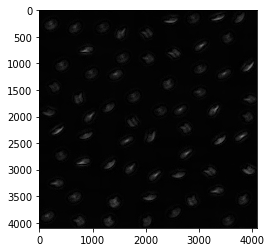

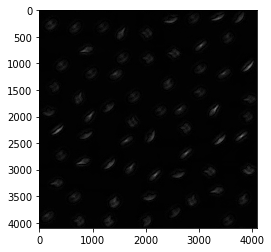

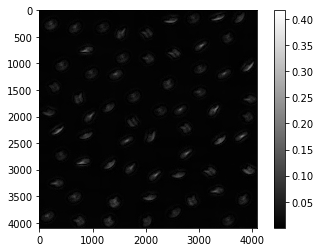

In [9]:
%%time
#MRC applicatble version 4 of code to take in a micrographs and stack of templates, and return a stack of nccs

def multi_particles4(I, T,specific_num = 0, use_numpy_ver = True):
    I = mrc.readMRC(I)
    T = mrc.readMRC(T)
    x,y,z = T.shape
    I = I[:,:,0]
    h, l = I.shape
    f1 = np.fft.rfft2(I)
    padding = np.zeros_like(I)
    
    xcent = int(h/2-x/2)
    ycent = int(l/2-y/2)
    
    padding[xcent:xcent+int(x), ycent:ycent+int(y)] = 1.0
    
    f2 = np.fft.rfft2(padding)
    
    mask = np.zeros_like(I)
    
    if not specific_num:
        specific_num = 3
        print('Not working yet')
        #specific_num = z
    
    ncc_stack = np.empty([h,l,specific_num])
    
    for nn in range(specific_num):
        zed = T[:,:,nn]
        zed = zed - np.mean(zed)
        
        mask[xcent:xcent+int(x), ycent:ycent+int(y)] = zed[::-1,::-1]
        
        crossc = fast_convolve(I, mask, use_numpy_ver, IFT=f1)
        denom1 = np.sqrt(fast_convolve(I**2, padding, use_numpy_ver, PFT = f2))
        denom2 = np.sqrt(np.sum(zed**2))
        
        ncc_stack[:,:,nn] = abs(crossc/(denom1*denom2))
        
        plt.figure()
        plt.imshow(ncc_stack[:,:,nn])
        
    return ncc_stack

def fast_convolve(I, T, use_numpy_ver, IFT = 0, PFT = 0):

    if use_numpy_ver:
        
        if np.any(IFT):
            f2 = np.fft.rfft2(T)
            conv = IFT*f2
            fc = np.fft.fftshift(np.fft.irfft2(conv))
        elif np.any(PFT):
            
            f1 = np.fft.rfft2(I)
            
            conv = f1*PFT
            fc = np.fft.fftshift(np.fft.irfft2(conv))
        else:
            f1 = np.fft.rfft2(I)
            f2 = np.fft.rfft2(T)

            conv = f1*f2
            fc = np.fft.fftshift(np.fft.irfft2(conv)) 
        
    else:
        fc = scipy.signal.fftconvolve(I,T,'same')
        
    return fc  


z = multi_particles4('imgdata_52006_1.mrc','imgdata_26005_particle_stack.mrc',3, use_numpy_ver = True)
plt.imshow(z[:,:,0])
plt.colorbar()

In [29]:
z = mrc.readMRC('imgdata_26005_particle_stack.mrc')
y = mrc.readMRC('imgdata_52006_1.mrc')
print(y[:,:,0].shape)
h,j = z.shape[0:2]


(4096, 4096)


0.0

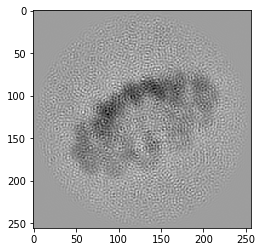

In [6]:
img =  mrc.readMRC('imgdata_26005_particle_stack_256.mrc')
# img.shape
# img2 = img[448:576,448:576,:]
# img2.shape
# mrc.writeMRC('imgdata_26005_particle_stack_128.mrc',img2)
plt.imshow(img[:,:,0])

Instead of calculating the NCC now, we calculate Ejk, which is the 'error' of projection j of template k. This is derived from a Gaussian noise approximation, and instead of calculating the NCC, we use the same results to calculate Ejk. $$ \mathcal{E}_{jk} = \frac{1}{2\sigma^2}\sum_i(I_i-T_i^{jk})^2 = \sum_i I_i^2 + \sum T_i^2 - 2\sum I_iT_i $$, where sigma is implictly defined as 1/sqrt(2) for now. 

Similar to the above code, this returns a stack of Ejk.

In [12]:
%%time
#MRC applicatble version 4 of code to take in a micrographs and stack of templates, and return a stack of nccs

def ejk(I, T,specific_num = 0, use_numpy_ver = True):
    I = mrc.readMRC(I)
    T = mrc.readMRC(T)
    x,y,z = T.shape
    I = I[:,:,0]
    h, l = I.shape
    f1 = np.fft.rfft2(I)
    padding = np.zeros_like(I)
    
    xcent = int(h/2-x/2)
    ycent = int(l/2-y/2)
    
    padding[xcent:xcent+int(x), ycent:ycent+int(y)] = 1.0
    
    f2 = np.fft.rfft2(padding)
    
    mask = np.zeros_like(I)
    
    if not specific_num:
        specific_num = 3
        print('Not working yet')
        #specific_num = z
    
    ejk_stack = np.empty([h,l,specific_num])
    
    for nn in range(specific_num):
        zed = T[:,:,nn]
        zed = zed - np.mean(zed)
        
        mask[xcent:xcent+int(x), ycent:ycent+int(y)] = zed[::-1,::-1]
        
        crossc = fast_convolve(I, mask, use_numpy_ver, IFT=f1)
        img_norm = fast_convolve(I**2, padding, use_numpy_ver, PFT = f2)
        temp_norm = np.sum(zed**2)        
        
        ejk_stack[:,:,nn] = (img_norm + temp_norm - 2*crossc)
     
    return ejk_stack

def fast_convolve(I, T, use_numpy_ver, IFT = 0, PFT = 0):

    if use_numpy_ver:
        
        if np.any(IFT):
            f2 = np.fft.rfft2(T)
            conv = IFT*f2
            fc = np.fft.fftshift(np.fft.irfft2(conv))
            
        elif np.any(PFT):
            
            f1 = np.fft.rfft2(I)
            
            conv = f1*PFT
            fc = np.fft.fftshift(np.fft.irfft2(conv))
        else:
            f1 = np.fft.rfft2(I)
            f2 = np.fft.rfft2(T)

            conv = f1*f2
            fc = np.fft.fftshift(np.fft.irfft2(conv)) 
        
    else:
        fc = scipy.signal.fftconvolve(I,T,'same')
        
    return fc  


z = ejk('imgdata_52006_1.mrc','imgdata_26005_particle_stack.mrc',3, use_numpy_ver = True)

Wall time: 14.5 s


In [107]:
# a,b,c = z.shape
# z1 = z[:,:,:5]
# z2 = z[:,:,5:10]

# s = scipy.misc.logsumexp(z, axis = 2)

# s1 = scipy.misc.logsumexp(z1, axis = 2)
# s2 = scipy.misc.logsumexp(z2, axis = 2)

t = scipy.misc.logsumexp([s1, s2], axis=0 )

print(s1.shape,s2.shape)
print(s.shape,t.shape)
print(s)
print('\n')
print(t)
t==s

(4096, 4096) (4096, 4096)
(4096, 4096) (4096, 4096)
[[1661546.95318402 1658661.1828657  1656097.32766934 ... 1668922.59166839
  1666484.11260885 1663844.72691341]
 [1659851.62796079 1656909.68958561 1654303.64569122 ... 1667272.99352737
  1664819.27995324 1662152.30559729]
 [1658214.65332969 1655281.88964287 1652675.17852251 ... 1665711.39345214
  1663217.4619833  1660526.2032046 ]
 ...
 [1665780.94611845 1662924.60405295 1660453.21771005 ... 1673064.61541885
  1670709.7813655  1668104.84404846]
 [1664441.99423037 1661585.73588848 1659111.70400982 ... 1671780.9651242
  1669378.37123247 1666761.47082712]
 [1662943.23604814 1660084.72338443 1657554.49298125 ... 1670305.33160199
  1667870.60730909 1665240.7401996 ]]


[[1661546.95318402 1658661.1828657  1656097.32766934 ... 1668922.59166839
  1666484.11260885 1663844.72691341]
 [1659851.62796079 1656909.68958561 1654303.64569122 ... 1667272.99352737
  1664819.27995324 1662152.30559729]
 [1658214.65332969 1655281.88964287 1652675.17852251 

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

As we do not care about the specific projection, we margianalize over j, and this is performed via LogSumExp, $$\mathcal{E} = -log\sum_j e^{-\mathcal{E}_{jk}}$$. This code takes the Ejk stack and performs a LSE on the negative of it, and then takes the negative again. 

In [10]:
%%time
#MRC applicatble version 4 of code to take in a micrographs and stack of templates, and return a stack of nccs
def Error_Particle(I, T,specific_num, use_numpy_ver = True):
    Error_Stack = Error_Template(I, T,specific_num, use_numpy_ver = True)
    Particle_Error = -scipy.misc.logsumexp(-Error_Stack,axis=2)
    return Particle_Error

def Error_Template(I, T,specific_num = 0, use_numpy_ver = True):
    I = mrc.readMRC(I)
    T = mrc.readMRC(T)
    x,y,z = T.shape
    I = I[:,:,0]
    h, l = I.shape
    f1 = np.fft.rfft2(I)
    padding = np.zeros_like(I)
    
    xcent = int(h/2-x/2)
    ycent = int(l/2-y/2)
    
    padding[xcent:xcent+int(x), ycent:ycent+int(y)] = 1.0
    
    f2 = np.fft.rfft2(padding)
    
    mask = np.zeros_like(I)
    
    if not specific_num:
        specific_num = 3
        print('Not working yet')
        #specific_num = z
    
    ejk_stack = np.empty([h,l,specific_num])
    
    for nn in range(specific_num):
        zed = T[:,:,nn]
        zed = zed - np.mean(zed)
        
        mask[xcent:xcent+int(x), ycent:ycent+int(y)] = zed[::-1,::-1]
        
        crossc = fast_convolve(I, mask, use_numpy_ver, IFT=f1)
        img_norm = fast_convolve(I**2, padding, use_numpy_ver, PFT = f2)
        temp_norm = np.sum(zed**2)        
        
        ejk_stack[:,:,nn] = (img_norm + temp_norm - 2*crossc)
     
    return ejk_stack

def fast_convolve(I, T, use_numpy_ver, IFT = 0, PFT = 0):

    if use_numpy_ver:
        
        if np.any(IFT):
            f2 = np.fft.rfft2(T)
            conv = IFT*f2
            fc = np.fft.fftshift(np.fft.irfft2(conv))
        elif np.any(PFT):
            
            f1 = np.fft.rfft2(I)
            
            conv = f1*PFT
            fc = np.fft.fftshift(np.fft.irfft2(conv))
        else:
            f1 = np.fft.rfft2(I)
            f2 = np.fft.rfft2(T)

            conv = f1*f2
            fc = np.fft.fftshift(np.fft.irfft2(conv)) 
        
    else:
        fc = scipy.signal.fftconvolve(I,T,'same')
        
    return fc  


z = Error_Particle('imgdata_52006_1.mrc','imgdata_26005_particle_stack.mrc',3, use_numpy_ver = True)

Wall time: 17.9 s


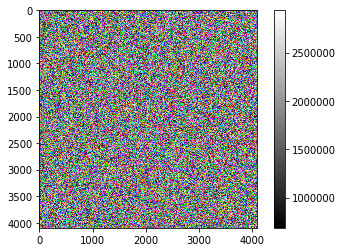

In [13]:
# img = mrc.readMRC('imgdata_26005_particle_stack.mrc')
# for nn in range(5):
#     plt.figure()
#     plt.imshow(img[:,:,nn])
#     plt.colorbar()
plt.figure()
plt.imshow(z)

plt.colorbar()

In [51]:
x = np.arange(10)
x1 = np.arange(5)
x2 = np.arange(5,10)
print(x,x1,x2)

s = scipy.misc.logsumexp(x)
s1 = scipy.misc.logsumexp(x1)
s2 = scipy.misc.logsumexp(x2)

print(s,s1,s2)

st = np.log(np.exp(s1)+np.exp(s2))

print(st)

[0 1 2 3 4 5 6 7 8 9] [0 1 2 3 4] [5 6 7 8 9]
9.45862974442671 4.451914395937593 9.451914395937594
9.458629744426712


Due to computatinal limits, only a certain amount of data can be passed to LSE at once, so this code takes in a parameter, max_num, which limits the amount passed at once. To do this, it breaks the projection stack into bins which contain under a max_num amount of projections. The Ek is calculated for that bin, and then all the bins are combined by again taking the LSE over all of them. 

In [53]:
%%time
#First version of a code that takes image, stack and max_num a computer can work with and produce EK
#This doesnt work for template stacks that have more bins than max_num
def Error_Particle(I, T, max_num):
    I = mrc.readMRC(I)
    T = mrc.readMRC(T)
    Error_Stack = Error_Template(I, T, max_num)
    Particle_Error = -scipy.misc.logsumexp(-Error_Stack, axis=2)
    return(Particle_Error)
    
def Error_Template(I, T, max_num):
    I = I[:,:,0]
    x, y, z = T.shape
    h, l = I.shape
    
    xcent = int(h/2-x/2)
    ycent = int(l/2-y/2)
    
    padding = np.zeros_like(I)
    padding[xcent:xcent+int(x), ycent:ycent+int(y)] = 1.0
    
    f1 = np.fft.rfft2(I)
    f2 = np.fft.rfft2(padding)
    
    mask = np.zeros_like(I)
    
    EK = Template_Splitting(I,T, x, y, z, xcent, ycent,h,l,f1, f2, padding, mask, max_num)
    
    return(EK)
    
def Template_Splitting(I, T, x, y, z, xcent, ycent, h, l, f1, f2, padding, mask, max_num, start = 0):
    
    bins = z//max_num
    
    if bins > max_num:
        print(bins)
    else:
        index = np.arange(start,z,max_num)
        ek_stack = np.empty([h, l, max_num])
        ejk_stack = np.empty([h, l, max_num])
        for nn in range(len(index)):
            tt = index[nn]
            zed = T[:,:,nn:nn+max_num]
            
            for xx in range(max_num):
                temp = zed[:,:,xx]
                temp = temp-np.mean(temp)
                
                mask[xcent:xcent+int(x), ycent:ycent+int(y)] = temp[::-1,::-1]
                
                crossc = fast_convolve(I, mask, IFT=f1)
                img_norm = fast_convolve(I**2, padding, PFT = f2)
                temp_norm = np.sum(temp**2)        
                
                ejk_stack[:,:,xx] = (img_norm + temp_norm - 2*crossc)
            
            ek_stack[:,:,nn] = -scipy.misc.logsumexp(-ejk_stack, axis=2)
            print('looping')
        
        return ek_stack
                
            
    
def fast_convolve(I, T, IFT = 0, PFT = 0):   
    if np.any(IFT):
        
        f2 = np.fft.rfft2(T)
        conv = IFT*f2
        fc = np.fft.fftshift(np.fft.irfft2(conv))
    elif np.any(PFT):
            
        f1 = np.fft.rfft2(I)
            
        conv = f1*PFT
        fc = np.fft.fftshift(np.fft.irfft2(conv))
    else:
        f1 = np.fft.rfft2(I)
        f2 = np.fft.rfft2(T)

        conv = f1*f2
        fc = np.fft.fftshift(np.fft.irfft2(conv)) 
   
    return fc    
    
    
z = Error_Particle('imgdata_52006_1.mrc','imgdata_26005_particle_stack.mrc',10)

looping
looping
looping
looping
looping
looping
looping
looping
looping
looping
Wall time: 8min 16s


In [94]:
# %%time
# #Second version of a code that takes image, stack and max_num a computer can work with and produce EK
# #Adding functionality for larger template stacks and division errors

# def Error_Particle(I, T, max_num):
#     I = mrc.readMRC(I)
#     T = mrc.readMRC(T)
#     Error_Stack = Error_Template(I, T, max_num)
#     Particle_Error = -scipy.misc.logsumexp(-Error_Stack, axis=2)
#     return(Particle_Error)
    
# def Error_Template(I, T, max_num):
#     I = I[:,:,0]
#     x, y, z = T.shape
#     h, l = I.shape
    
#     xcent = int(h/2-x/2)
#     ycent = int(l/2-y/2)
    
#     padding = np.zeros_like(I)
#     padding[xcent:xcent+int(x), ycent:ycent+int(y)] = 1.0
    
#     f1 = np.fft.rfft2(I)
#     f2 = np.fft.rfft2(padding)
    
#     mask = np.zeros_like(I)
    
#     EK = Template_Splitting(I,T, x, y, z, xcent, ycent,h,l,f1, f2, padding, mask, max_num)
    
#     return(EK)
    
# def Template_Splitting(I, T, x, y, z, xcent, ycent, h, l, f1, f2, padding, mask, max_num, start = 0):
    
#     bins = z//max_num
    
#     if bins > max_num:
#         metabin = bins//max_num
#         if metabin > max_num:
#             ejk_stack = np. empty([h,l,bins//max_num])
#             ypu = np.linspace(0, z, 15, dtype = int)
            
#             for nn in range(max_num):
#                 try:
#                     slicetemp = T[:,:,ypu[nn]:ypu[nn+1]]
#                 except IndexError:
#                     slicetemp = T[:,:,ypu[nn]:]
                
#                 x,y,height = slicetemp.shape
                
#                 pp = Template_Splitting(I, slicetemp, x, y, height, xcent, ycent, h, l ,f1, f2, padding, mask, max_num)
                
#                 ek_stack[:,:,nn] = pp
                
#                 return ek_stack
                
            
#         else:
#             for nn in range(metabin+1):

#                 rr = nn*max_num**2
#                 slicet = T[:,:,rr:rr+max_num**2]
#                 height = T.shape[2] 

#                 pp = Template_Splitting(I, slicet, x, y, height, xcent, ycent, h, l ,f1, f2, padding, mask, max_num)
                
            
#     else:
        
#         index = np.arange(start,z,max_num)
#         ek_stack = np.empty([h, l, max_num])
#         ejk_stack = np.empty([h, l, max_num])
        
#         for nn in range(len(index)):
#             tt = index[nn]
#             zed = T[:,:,nn:nn+max_num]
            
#             for xx in range(max_num):
#                 temp = zed[:,:,xx]
#                 temp = temp-np.mean(temp)
                
#                 mask[xcent:xcent+int(x), ycent:ycent+int(y)] = temp[::-1,::-1]
                
#                 crossc = fast_convolve(I, mask, IFT=f1)
#                 img_norm = fast_convolve(I**2, padding, PFT = f2)
#                 temp_norm = np.sum(temp**2)        
                
#                 ejk_stack[:,:,xx] = (img_norm + temp_norm - 2*crossc)
            
#             ek_stack[:,:,nn] = -scipy.misc.logsumexp(-ejk_stack, axis=2)
            
#             print('looping')
        
#         return ek_stack
                
            
    
# def fast_convolve(I, T, IFT = 0, PFT = 0):   
#     if np.any(IFT):
        
#         f2 = np.fft.rfft2(T)
#         conv = IFT*f2
#         fc = np.fft.fftshift(np.fft.irfft2(conv))
#     elif np.any(PFT):
            
#         f1 = np.fft.rfft2(I)
            
#         conv = f1*PFT
#         fc = np.fft.fftshift(np.fft.irfft2(conv))
#     else:
#         f1 = np.fft.rfft2(I)
#         f2 = np.fft.rfft2(T)

#         conv = f1*f2
#         fc = np.fft.fftshift(np.fft.irfft2(conv)) 
   
#     return fc    
    
    
# #z = Error_Particle('imgdata_52006_1_1024.mrc','testfile.mrc',10)

Wall time: 0 ns


If the amount of bins is greater than max_num, the code needs to become recursive and pass a section of the template stack into the code. Also, for the ending of the stack, the code was slightly adjusted as it wouldnt necessarily be the same number of projections as the other slices. 

In [6]:
%%time
#Second version of a code that takes image, stack and max_num a computer can work with and produce EK
#Adding functionality for larger template stacks and division errors
def Error_Particle(I, T, max_num):
    I = mrc.readMRC(I)
    T = mrc.readMRC(T)
    Error_Stack = Error_Template(I, T, max_num)
    Particle_Error = -scipy.misc.logsumexp(-Error_Stack, axis=2)
    print('############################')
    return(Particle_Error)
    
def Error_Template(I, T, max_num):
    I = I[:,:,0]
    x, y, z = T.shape
    h, l = I.shape
    
    xcent = int(h/2-x/2)
    ycent = int(l/2-y/2)
    
    padding = np.zeros_like(I)
    padding[xcent:xcent+int(x), ycent:ycent+int(y)] = 1.0
    
    f1 = np.fft.rfft2(I)
    f2 = np.fft.rfft2(padding)
    
    mask = np.zeros_like(I)
    
    EK = Template_Splitting(I,T, x, y, z, xcent, ycent,h,l,f1, f2, padding, mask, max_num)
    print(np.isfortran(EK))
    return(EK)
    
def Template_Splitting(I, T, x, y, z, xcent, ycent, h, l, f1, f2, padding, mask, max_num, start = 0):
    
    bins = z//max_num
    
    if bins > max_num:
        indices = np.linspace(0,z,max_num+1, dtype = int)
        total_stack = np.empty([h,l,max_num])
        
        for nn in range(max_num):
            slicet = T[:,:,indices[nn]:indices[nn+1]]
            height = slicet.shape[2]

            pp = Template_Splitting(I, slicet, x, y, height, xcent, ycent, h, l ,f1, f2, padding, mask, max_num)
            total_stack[:,:,nn] = -scipy.misc.logsumexp(-pp, axis=2)
        return total_stack
                   
    else:
        
        index = np.arange(start,z,max_num)
        inx_len = len(index)
        ek_stack = np.empty([h, l, inx_len])
        
        ejk_stack = np.empty([h, l, max_num])
        
        for nn in range(inx_len):
            try:
                zed = T[:,:,index[nn]:index[nn+1]]
                
            except IndexError:
                zed = T[:,:,index[nn]:]
                ejk_stack = np.empty([h,l,z-index[nn]])      
            
            for xx in range(zed.shape[2]):
                print('heythere')
                
                
                temp = zed[:,:,xx]
                temp = temp-np.mean(temp)
                
                mask[xcent:xcent+int(x), ycent:ycent+int(y)] = temp[::-1,::-1]
                
                crossc = fast_convolve(I, mask, IFT=f1)
                img_norm = fast_convolve(I**2, padding, PFT = f2)
                temp_norm = np.sum(temp**2)        
                
                ejk_stack[:,:,xx] = (img_norm + temp_norm - 2*crossc)
            
            ek_stack[:,:,nn] = -scipy.misc.logsumexp(-ejk_stack, axis=2)
            
            print('looping')
        
        return ek_stack
                       
    
def fast_convolve(I, T, IFT = 0, PFT = 0):   
    if np.any(IFT):
        
        f2 = np.fft.rfft2(T)
        conv = IFT*f2
        fc = np.fft.fftshift(np.fft.irfft2(conv))
    elif np.any(PFT):
            
        f1 = np.fft.rfft2(I)
            
        conv = f1*PFT
        fc = np.fft.fftshift(np.fft.irfft2(conv))
    else:
        f1 = np.fft.rfft2(I)
        f2 = np.fft.rfft2(T)

        conv = f1*f2
        fc = np.fft.fftshift(np.fft.irfft2(conv)) 
   
    return fc    
    
    
EKTEST1 = Error_Particle('imgdata_52006_1.mrc','imgdata_26005_particle_stack.mrc',15)

heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
looping
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
looping
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
looping
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
looping
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
looping
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
looping
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
looping
False
############################
Wall time

As the order of the array dictates the way information is rapidly added to the array, I ensured that each part of my code dealt with C ordered arrays, increasing efficiency. 

In [7]:
%%time
#Third version of a code that takes image, stack and max_num a computer can work with and produce EK
#Adding functionality for larger template stacks and division errors
#Changing the ordering of the array to conform to C ordering for efficiency
def Error_Particle(I, T, max_num):
    I = mrc.readMRC(I)
    T = mrc.readMRC(T)
    T = np.ascontiguousarray(T)
    Error_Stack = Error_Template(I, T, max_num)
    Particle_Error = -scipy.misc.logsumexp(-Error_Stack, axis=0)
    print('############################')
    return(Particle_Error)
    
def Error_Template(I, T, max_num):
    I = I[:,:,0]
    x, y, z = T.shape
    h, l = I.shape
    
    xcent = int(h/2-x/2)
    ycent = int(l/2-y/2)
    
    padding = np.zeros_like(I)
    padding[xcent:xcent+int(x), ycent:ycent+int(y)] = 1.0
    
    f1 = np.fft.rfft2(I)
    f2 = np.fft.rfft2(padding)
    
    mask = np.zeros_like(I)
    
    EK = Template_Splitting(I,T, x, y, z, xcent, ycent,h,l,f1, f2, padding, mask, max_num)
    
    return(EK)
    
def Template_Splitting(I, T, x, y, z, xcent, ycent, h, l, f1, f2, padding, mask, max_num, start = 0):
    
    bins = z//max_num
    
    if bins > max_num:
        indices = np.linspace(0,z,max_num+1, dtype = int)
        total_stack = np.empty([max_num, h, l])
        
        for nn in range(max_num):
            slicet = T[:,:,indices[nn]:indices[nn+1]]
            height = slicet.shape[2]

            pp = Template_Splitting(I, slicet, x, y, height, xcent, ycent, h, l ,f1, f2, padding, mask, max_num)
            total_stack[nn,:,:] = -scipy.misc.logsumexp(-pp, axis=0)
        return total_stack
                   
    else:
        
        index = np.arange(start,z,max_num)
        inx_len = len(index)
        ek_stack = np.empty([inx_len, h, l])
        
        
        ejk_stack = np.empty([max_num,h, l])
        
        
        for nn in range(inx_len):
            try:
                zed = T[:,:,index[nn]:index[nn+1]]
                
            except IndexError:
                zed = T[:,:,index[nn]:]
                ejk_stack = np.empty([z-index[nn],h,l])      
            
            for xx in range(zed.shape[2]):
                print('heythere')
                
                
                temp = zed[:,:,xx]
                temp = temp-np.mean(temp)
                
                mask[xcent:xcent+int(x), ycent:ycent+int(y)] = temp[::-1,::-1]
                
                crossc = fast_convolve(I, mask, IFT=f1)
                img_norm = fast_convolve(I**2, padding, PFT = f2)
                temp_norm = np.sum(temp**2)        
                
                ejk_stack[xx,:,:] = (img_norm + temp_norm - 2*crossc)
                
            
            ek_stack[nn,:,:] = -scipy.misc.logsumexp(-ejk_stack, axis=0)
           
            
            print('looping')
        
        return ek_stack
                       
    
def fast_convolve(I, T, IFT = 0, PFT = 0):   
    if np.any(IFT):
        
        f2 = np.fft.rfft2(T)
        conv = IFT*f2
        fc = np.fft.fftshift(np.fft.irfft2(conv))
    elif np.any(PFT):
            
        f1 = np.fft.rfft2(I)
            
        conv = f1*PFT
        fc = np.fft.fftshift(np.fft.irfft2(conv))
    else:
        f1 = np.fft.rfft2(I)
        f2 = np.fft.rfft2(T)

        conv = f1*f2
        fc = np.fft.fftshift(np.fft.irfft2(conv)) 
   
    return fc    
    
    
EKTEST2 = Error_Particle('imgdata_52006_1.mrc','imgdata_26005_particle_stack.mrc',15)

heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
looping
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
looping
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
looping
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
looping
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
looping
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
looping
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
heythere
looping
############################
Wall time: 7min

(4096, 4096)
[[1326528.78771002 1323647.56461479 1321077.7330885  ... 1333905.32997532
  1331464.88143233 1328818.45598054]
 [1324819.38954082 1321913.48410017 1319341.48113149 ... 1332245.24189665
  1329812.31278395 1327126.86139712]
 [1323192.39982561 1320293.46076786 1317691.67793096 ... 1330710.86386377
  1328257.26818706 1325529.07600098]
 ...
 [1330780.3252118  1327981.56748186 1325505.47583635 ... 1338095.38761909
  1335695.12786444 1333056.85233673]
 [1329497.63812139 1326659.35989722 1324123.92438963 ... 1336840.23020476
  1334394.057094   1331763.26836243]
 [1327989.04794376 1325110.87043312 1322509.82308853 ... 1335344.84693805
  1332891.56938556 1330259.13478451]] 

[[1326528.73919156 1323647.51610179 1321077.68458198 ... 1333905.28144161
  1331464.83290393 1328818.40745771]
 [1324819.34102466 1321913.43558923 1319341.43262707 ... 1332245.19336479
  1329812.26425764 1327126.81287666]
 [1323192.35131182 1320293.41225922 1317691.62942885 ... 1330710.81533418
  1328257.2196632

302114.9

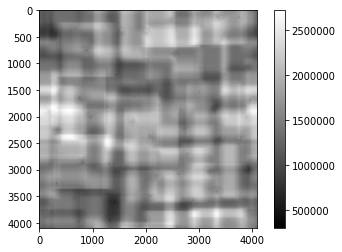

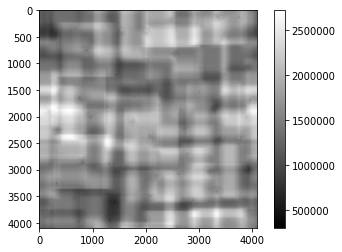

In [69]:
print(EKTEST2.shape)
plt.figure()
plt.imshow(EKTEST1)
plt.colorbar()
plt.figure()
plt.imshow(EKTEST2)
plt.colorbar()
print(EKTEST1, '\n')
print(EKTEST2)
#scipy.misc.imsave('look91.png', z)
# ffr = (np.linspace(0,142349,15+1, dtype = int))
# print(ffr)
# x=0
# print(type(ffr[2]))
# for nn in range(15):
#     print(ffr[nn],ffr[nn+1])
#     x+=1
    
# print(x)
# test = np.arange(0,100,33)
# print(len(test))
# for nn in range(len(test)):
#     tt = test[nn]
    
#     print(tt)
# zed = np.empty([5,5,10])
# zed.shape[2]
Q1 = np.round(EKTEST1, decimals=1)
Q2 = np.round(EKTEST2, decimals=1)
np.min(Q2)

In [27]:
z = np.random.rand(3,3,3)
print(z)
z[1,1,1]

[[[0.43036439 0.36270515 0.71323276]
  [0.60866593 0.5878388  0.1016879 ]
  [0.69817082 0.65953115 0.59226942]]

 [[0.96476633 0.42311908 0.21256566]
  [0.83170436 0.45071762 0.18856399]
  [0.30119083 0.40423616 0.4789892 ]]

 [[0.51192865 0.3962355  0.83086126]
  [0.82136535 0.24857469 0.20590709]
  [0.04745459 0.23213625 0.11923121]]]


0.450717617047216

In [22]:
T = mrc.readMRC('imgdata_26005_particle_stack.mrc')
t = T[:,:,:50]
t.shape
mrc.writeMRC('testfile50.mrc', t)